# This Notebook checks the impact of 1/f noise in TDM.
### L. Ravera @IRAP
### March 17, 2022
In this simulation we create the signal of a TES (pulses). Then we simulates the multiplexing stage in the SQUID (modulation of the signal with a square). Then we add a low frequency sine wave in the signal (supposed to mimic a perturbation). Then we demodulates the signal in the same way the DRE does. We plot time and frequency representations of the signal along this processing to verify how the noise perturbation changes.
The question we want to answer with this simulation is: Does the TDM modulation remove the low noise contributions of the redout chain?

*Conclusion:
From this simulation it seems that the low noise contributions of the readout chain are not removed by the TDM porocessing (too bad).*

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# Definition of constants

# TDM parameters
NMux = 34
TRow = 160e-9
FRow = 1/TRow
TFrame = NMux*TRow
FFrame = 1/TFrame
samples_per_row = 20
FADC = FRow * samples_per_row
nsamples_avg_DRE = 5 # number of samples considered in DRE to apply the average

# Pulse parameters
Tau_fall = 796e-6
Tau_rise = 96.8e-6 
A = 10000 # signal amplitude
NPulses = 2  # Number of pulses in the simulation

# Noise parameters
FPerturbation = 1e2
APerturbation = 500

# Simulation parameters
Analog_ratio = 4
Fa = FADC * Analog_ratio   # Analog sampling frequency (Hz) (to simulate analogue behaviour)
Sim_length = 1  # Duration of the simulation (s)
npoint_per_frame = samples_per_row * Analog_ratio * NMux
npoints = int (int(Fa * Sim_length / npoint_per_frame) * npoint_per_frame) # Using full frames
#npoints = 2**int(np.log(Sim_length * Fa)/np.log(2)) # Shortenned to the closest power of 2

# Plot parameters
figx=2  # number of columns
figy=4  # number of lines

In [3]:
# Computing TES signal
def make_TES_signal(A, Tau_rise, Tau_fall, NPulses, npoints):
    print("Computing TES signal ...")
    time = np.arange(npoints) / Fa
    time_slot = time[:int(npoints/NPulses)]
    SinglePulse = A * (np.exp(-time_slot/Tau_rise) - np.exp(-time_slot/Tau_fall))
    Pulse = np.zeros(npoints)
    Pulse[:NPulses*len(time_slot)] += np.tile(SinglePulse, NPulses)
    
    return(time, Pulse)

In [4]:
# Oscilloscope
def plot_signal(t, sig, fig_i=1, title=''):
    ax=fig.add_subplot(figy, figx, fig_i)
    ax.plot(t, sig)
    ax.set_xlabel(r'Time [s]')
    ax.set_ylabel(r'Amplitude [V]')
    ax.set_title(title)

In [5]:
# Spectrum analyser
def plot_spectrum(sig, fs, nps=2**24, window='hann', fig_i=1, title=''):
    freq, Pxx_den = signal.welch(sig, fs, window, nperseg=nps)

    ax=fig.add_subplot(figy, figx, fig_i)
    ax.loglog(freq, Pxx_den)
    ax.loglog(freq, Pxx_den, '.')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.set_ylabel(r'PSD [V**2/Hz]')
    ax.set_xlim(10, 10e6)
    ax.grid()
    ax.set_title(title)

In [6]:
# MUX SQUID Modulation 
def modul(time, sig):
    print("Modulating signal ...")
    Na_per_row = int(Fa / FRow)
    Nb_squares = int(npoints / (NMux*Na_per_row))
    slice = np.zeros(NMux*Na_per_row)
    slice[:Na_per_row]=np.ones(Na_per_row)
    modul = np.tile(slice, Nb_squares+1)
    modul = modul[:len(time)]
    
    return(sig*modul)

In [7]:
# DRE sampling
def dre_adc(time, sig, ratio):
    print("Sampling the signal at fs ={0:4.0f} MHz ...".format(FADC/1e6))

    return(time[0::ratio], sig[0::ratio])

In [8]:
# DRE demodulation
# This functions samples 1 values per frame for pixel 0
def demodul(time, sig, npts):
    print("Demodulating signal with an average on {0:1d} samples ...".format(npts))
    ratio = int(NMux*samples_per_row)
    sig_DRE = np.zeros(int(len(sig)/ratio))
    for i in range(npts):
        index=int(FADC/FRow)-1-i
        print("   Using sampple: {0:2d}".format(index))
        sig_DRE += sig[index::ratio]
    sig_DRE = sig_DRE/npts
    time = time[0::ratio]

    return(time, sig_DRE)

In [9]:
# Addition of a LF perturbation
def add_sine(sig, t, f_per, a_per):
    print("Adding a sine wave at {0:5.0f} Hz ...".format(f_per))
    sig += a_per*np.sin(2*np.pi*f_per*t)
    
    return(sig)

Simulation duration is  1.00 s
Mux factor:         34
Frow:          6250000 Hz
Fframe:         183824 Hz
Fsampling:         125 MHz
Fperturbation:     100 Hz
----------
Computing TES signal ...
Modulating signal ...
Adding a sine wave at   100 Hz ...
Sampling the signal at fs = 125 MHz ...
Demodulating signal with an average on 5 samples ...
   Using sampple: 19
   Using sampple: 18
   Using sampple: 17
   Using sampple: 16
   Using sampple: 15
DRE is finished
Plots are done 1
Plots are done 2


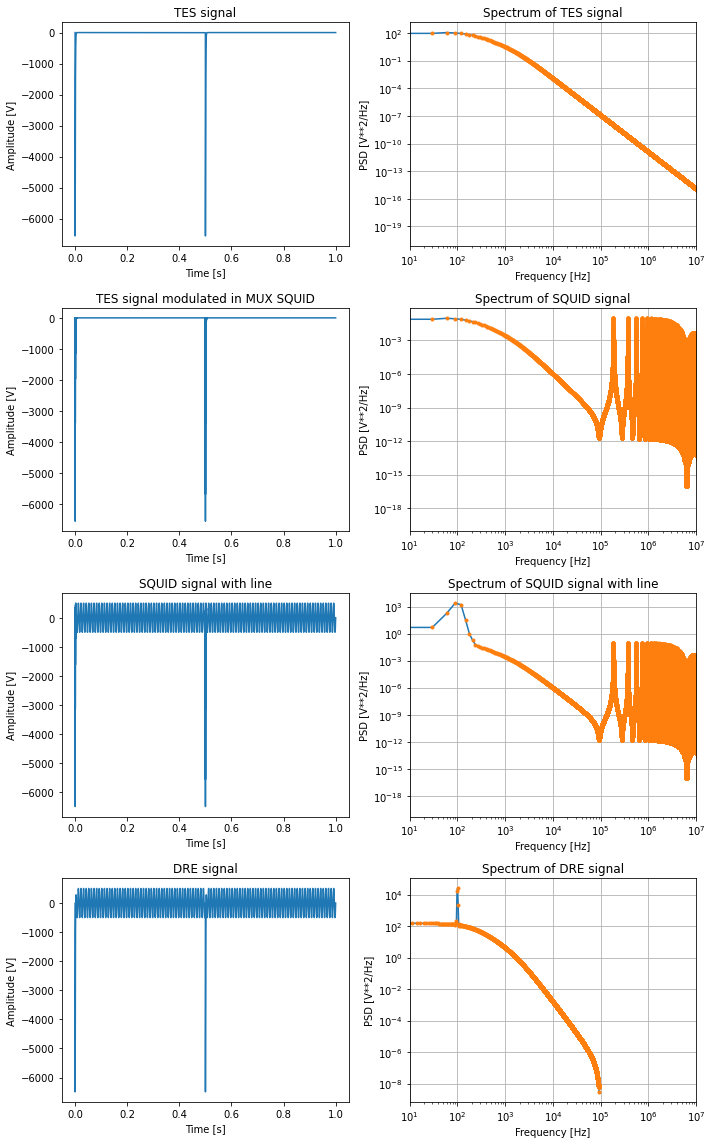

Done!


In [10]:

# Displaying some informations
print("Simulation duration is {0:5.2f} s".format(Sim_length))
print("Mux factor:    {0:7d}".format(NMux))
print("Frow:          {0:7.0f} Hz".format(FRow))
print("Fframe:        {0:7.0f} Hz".format(FFrame))
print("Fsampling:     {0:7.0f} MHz".format(FADC/1e6))
print("Fperturbation: {0:7.0f} Hz".format(FPerturbation))
print('----------')

fig=plt.figure(1,(10,16))

# Computing TES signal
time, Pulse = make_TES_signal(A, Tau_rise, Tau_fall, NPulses, npoints)
plot_signal(time, Pulse, fig_i=1, title="TES signal")
plot_spectrum(Pulse, Fa, window='hann', fig_i=2, title="Spectrum of TES signal")

# Simulating TDM in SQUID
sig_SQUID = modul(time, Pulse)
Pulse=0
plot_signal(time, sig_SQUID, fig_i=3, title="TES signal modulated in MUX SQUID")
plot_spectrum(sig_SQUID, Fa, window='hann', fig_i=4, title="Spectrum of SQUID signal")

# Simulating perturbation in the TDM signal
sig_perturb = add_sine(sig_SQUID, time, FPerturbation, APerturbation)
sig_SQUID=0
plot_signal(time, sig_perturb, fig_i=5, title="SQUID signal with line")
plot_spectrum(sig_perturb, Fa, window='hann', fig_i=6, title="Spectrum of SQUID signal with line")

# Simulating ADC sampling in DRE (AA filter is not applied)
time_adc, sig_adc = dre_adc(time, sig_perturb, Analog_ratio)
sig_perturb=0

# Simulating demodulation in DRE
time_DRE, sig_DRE = demodul(time_adc, sig_adc, nsamples_avg_DRE)
sig_adc=0
print("DRE is finished")
plot_signal(time_DRE, sig_DRE, fig_i=7, title="DRE signal")
plot_spectrum(sig_DRE, FFrame, nps=2**16, window='hann', fig_i=8, title="Spectrum of DRE signal")
print("Plots are done 1")

fig.tight_layout()
plt.savefig('1over_noise.png', dpi=300, bbox_inches='tight')
print("Plots are done 2")

plt.show()

print("Done!")